In [1]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.


In [20]:
import os
import random

directory = '/Users/andreykotlyakov/Downloads/data'
symbols = [f.replace('times', 'T') for f in os.listdir(directory) if f != '.ipynb_checkpoints' and f != '.DS_Store']
strings = [' '.join(''.join(random.choices(symbols, k=random.randint(3, 5))) for _ in range(2)) for _ in range(10)]

print(f"Символы: {symbols}\nСтроки: {strings}")

Символы: ['T', '9', '0', '7', '+', ',', '6', '1', '8', 't', '-', 'h', '(', '4', 'X', '3', ')', '2', 'y', '5', 'w']
Строки: ['2y4( 6h71', '7X46t 10+,+', 'y2X X95X', 't7-74 54+-', 't,w 5X7w', '1h67 89)6)', '(T- 80y', '+8X88 ,w01', '056 5X(6T', '3Tt)w h+)h']


In [21]:
def get_symbol_images_map(directory, symbols):
    symbol_images = {}
    for symbol in symbols:
        folder = os.path.join(directory, symbol if symbol != 'times' else 'T')
        symbol_images[symbol] = [os.path.join(folder, img) for img in os.listdir(folder)]
    return symbol_images

In [22]:
def get_string_images_map(strings, symbol_images):
    string_images = {}
    for string in strings:
        images = [
            symbol_images[char][random.randint(0, len(symbol_images[char]) - 1)] if char != ' ' else 'space'
            for char in string
        ]
        string_images[string] = images
    return string_images

In [23]:
from PIL import Image
def combine_images_with_spaces(images, min_scale=0.8, max_scale=0.9, max_offset=50, spacing=10, space_width=20):
    scaled_images = []

    for img_path in images:
        if img_path == 'space':
            space_img = Image.new('RGB', (space_width, 1), (255, 255, 255))
            scaled_images.append(space_img)
        else:
            img = Image.open(img_path)
            scale = random.uniform(min_scale, max_scale)
            img = img.resize((int(img.width * scale), int(img.height * scale)), Image.LANCZOS)
            scaled_images.append(img)

    total_width = sum(img.width for img in scaled_images) + spacing * (len(scaled_images) - 1)
    max_height = max(img.height for img in scaled_images) + max_offset
    combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    x_offset = 0
    for img in scaled_images:
        y_offset = random.randint(0, max_offset)
        combined_image.paste(img, (x_offset, y_offset))
        x_offset += img.width + spacing

    return combined_image

In [24]:
symbol_images = get_symbol_images_map(directory, symbols)
string_images = get_string_images_map(strings, symbol_images)

Matplotlib is building the font cache; this may take a moment.


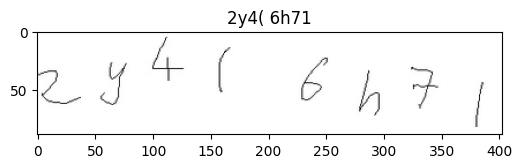

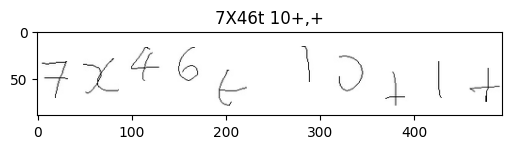

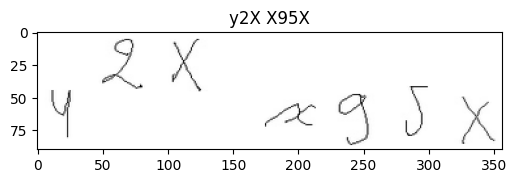

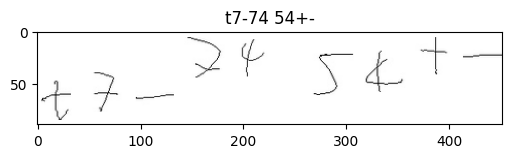

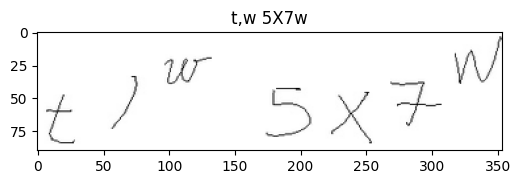

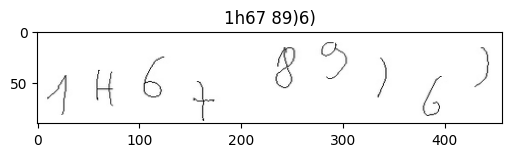

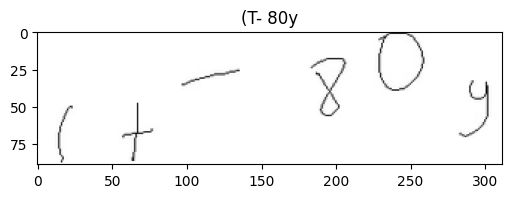

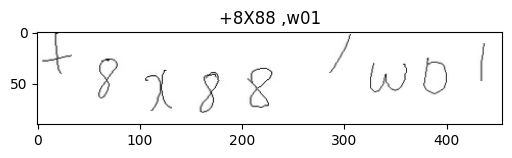

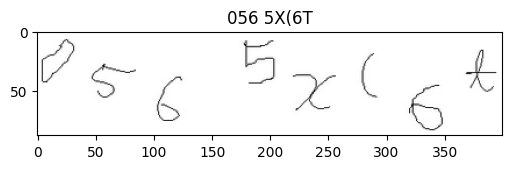

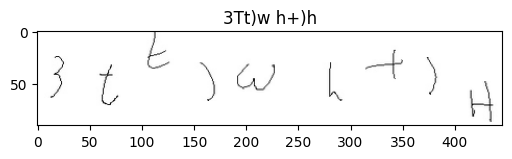

In [26]:
import numpy as np

output_directory = 'generated_images'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

generated_images_paths = {}

import matplotlib.pyplot as plt
for i, (string, images) in enumerate(string_images.items(), start=1):
    combined_image = combine_images_with_spaces(images)

    image_path = f'{output_directory}/{i}.png'
    combined_image.save(image_path)

    generated_images_paths[string] = image_path

    plt.figure(figsize=(6, 6))
    plt.imshow(combined_image)
    plt.title(string)
    plt.show()

In [45]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def get_cv_image(image):
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    return image

def get_vector(image):
    image = get_cv_image(image)

    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return cv2.resize(image[y:y+h, x:x+w], (28, 28)).flatten()

    return None

def prepare_data(data_dict):
    X = []
    y = []

    def process_label_images(label, img_paths):
        vectors = []
        labels = []
        for path in img_paths:
            vector = get_vector(path)
            if vector is not None:
                vectors.append(vector)
                labels.append(label)
        return vectors, labels

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda item: process_label_images(*item), data_dict.items()))

    for vectors, labels in results:
        X.extend(vectors)
        y.extend(labels)

    return np.array(X), np.array(y)

In [46]:
from sklearn.model_selection import train_test_split
symbol_images = get_symbol_images_map(directory, symbols)
X, y = prepare_data(symbol_images)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def find_optimal_k(X_train, y_train, k_range=(1, 10)):
    param_grid = {'n_neighbors': list(range(k_range[0], k_range[1] + 1))}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_['n_neighbors']

In [ ]:
optimal_k = find_optimal_k(X_train, y_train)
print(f"Optimal k = {optimal_k}")

In [49]:
from sklearn.metrics import accuracy_score

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {accuracy}")

Classification accuracy: 0.9767880522823602


In [50]:
import pickle

model_path = 'knn_model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump(knn_classifier, model_file)

In [51]:
def extract_symbols(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]

    dilated = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    rects = [cv2.boundingRect(c) for c in cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]

    rects.sort(key=lambda r: r[0])

    symbols = [get_vector(image[y:y+h, x:x+w]) for (x, y, w, h) in rects]

    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    return symbols

In [53]:
from difflib import SequenceMatcher
import editdistance

def calculate_cer(true_text, predicted_text):
    return editdistance.eval(true_text, predicted_text) / len(true_text) if len(true_text) > 0 else 0

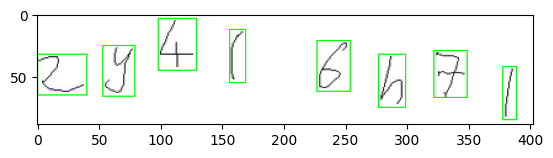

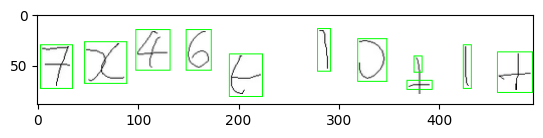

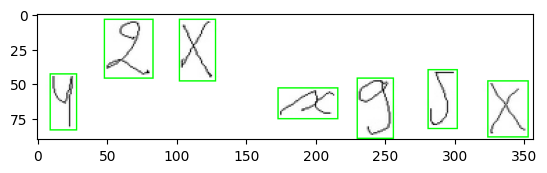

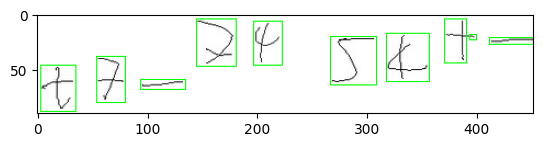

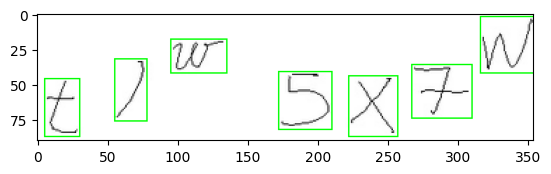

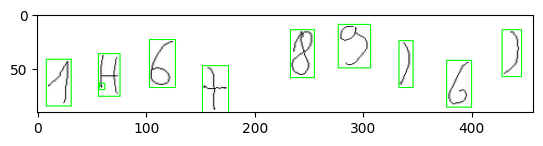

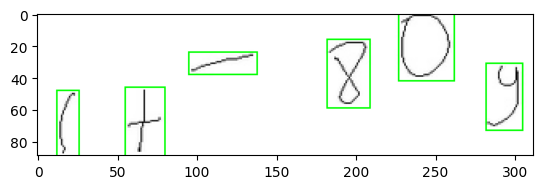

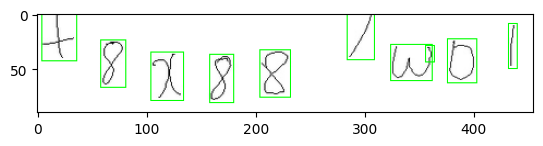

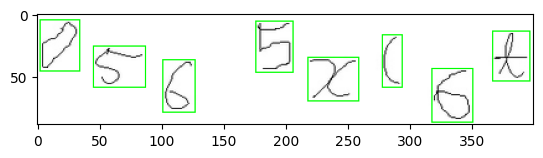

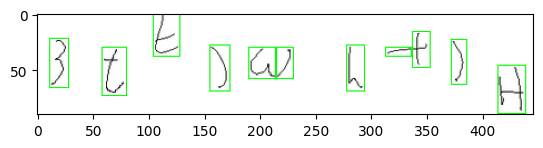

In [54]:
results = []

def restore_text_from_image(image_path, model, true_string, max_symbols_per_string=10):

    symbol_vectors = extract_symbols(image_path)

    predicted_symbols = model.predict(symbol_vectors)

    restored_text = ''.join(predicted_symbols)
    cer = calculate_cer(true_string, restored_text)
    results.append((true_string, predicted_symbols, cer))

    restored_text = ''.join(predicted_symbols)
    return restored_text, cer

with open(model_path, 'rb') as file:
    model = pickle.load(file)

restored_string = {}

for string, image_path in generated_images_paths.items():
    restored_text, cer = restore_text_from_image(image_path, model, string)

    if restored_text:
        restored_string[string] = restored_text

In [56]:
from pandas import DataFrame, concat
df_results = DataFrame(results, columns=['Исходная строка', 'Предсказанная строка', 'CER'])
df_results

,Исходная строка,Предсказанная строка,CER
0,2y4( 6h71,"[X, -, 4, (, 0, h, -, 1]",0.555556
1,"7X46t 10+,+","[1, X, 1, X, 0, 1, ), -, 1, ,, +]",0.727273
2,y2X X95X,"[1, 2, y, X, 9, 1, 1]",0.625000
3,t7-74 54+-,"[T, 7, -, ,, 1, 5, 4, 1, ,, -]",0.600000
4,"t,w 5X7w","[+, ,, ), 5, 1, +, +]",0.750000
5,1h67 89)6),"[1, -, +, 6, 1, 8, X, ), (, )]",0.600000
6,(T- 80y,"[-, +, -, 2, 0, y]",0.571429
7,"+8X88 ,w01","[+, 8, X, 8, 8, -, 1, ), (, y]",0.500000
8,056 5X(6T,"[0, 5, 6, 5, ), X, 6, -]",0.444444
9,3Tt)w h+)h,"[3, y, (, ), 1, 1, (, -, (, -, h]",0.800000


In [57]:
def modify_text(text, delete_prob=0.1, insert_prob=0.1):
    modified_text = []
    for char in text:
        if random.random() > delete_prob:
            modified_text.append(char)

        if random.random() < insert_prob:
            modified_text.append(chr(random.randint(32, 126)))

    return ''.join(modified_text)

In [58]:
for idx, row in df_results.iterrows():
    original_text = row["Исходная строка"]
    predicted_text = row["Предсказанная строка"]

    modified_predicted_text = modify_text(predicted_text)

    cer = calculate_cer(original_text, modified_predicted_text)

    df_results.at[idx, "Предсказанная строка"] = modified_predicted_text
    df_results.at[idx, "CER"] = cer

df_results

,Исходная строка,Предсказанная строка,CER
0,2y4( 6h71,X-]4(0h-1,0.666667
1,"7X46t 10+,+","1XH101)-1,+",0.727273
2,y2X X95X,1!2yX911,0.750000
3,t7-74 54+-,"T<7-1541q,K-0",0.900000
4,"t,w 5X7w","+`,)51++",0.875000
5,1h67 89)6),1-+618)(),0.600000
6,(T- 80y,-k+-20y,0.714286
7,"+8X88 ,w01",Xu88-1)(y,0.800000
8,056 5X(6T,0565)X6l-,0.555556
9,3Tt)w h+)h,3y)11(-(h,0.700000
